# Hagelslag Jet Streak Tracking Demo
David John Gagne

The goal of this tutorial is to show how you can adapt Hagelslag to track jet streaks for assessing tornado outbreak potential. First we will import the necessary libraries. If you haven't already, please create a new conda environment to support this notebook by running 
`mamba env create -f ../environment.yml` and restarting the notebook within the new environment.

In [1]:
%matplotlib inline
import numpy as np
from hagelslag.data.HRRRZarrModelGrid import HRRRZarrModelGrid
from hagelslag.data.ModelOutput import ModelOutput
import hagelslag.processing.tracker as tracker
from hagelslag.processing.ObjectMatcher import nonoverlap
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd
from scipy.ndimage import label, gaussian_filter
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

This section loads HRRR output from the [AWS/U. Utah HRRR Zarr archive](https://registry.opendata.aws/noaa-hrrr-pds/). Change the run date to download a different run. By default, the forecast hour range is set to 24 hours, but you can choose a different forecast period if you wish. If you want to run the tracking on a different pressure level, change the pressure level variable to one of the standard pressure levels. 

In [3]:
run_date = pd.Timestamp("2023-11-30 00:00")
pressure_level = 500
start_f_hour = 12
end_f_hour = 36
start_date = run_date + pd.Timedelta(hours=start_f_hour)
end_date = start_date + pd.Timedelta(hours=end_f_hour - start_f_hour)
fh = pd.date_range(start_date, end_date, freq="1H") - run_date
forecast_hours = fh.values.astype("timedelta64[h]").astype(int)
ensemble = "HRRR-ZARR"
member = "sfc"
map_file = "../maps/hrrr_map_2016.txt"
model_path = "hrrrzarr/sfc"
# Load u and v fields and mapping info
u_500_zarr = ModelOutput(ensemble, member, run_date, f"UGRD-{pressure_level:d}mb", start_date, end_date, model_path, map_file)
u_500_zarr.load_data()
v_500_zarr = ModelOutput(ensemble, member, run_date, f"VGRD-{pressure_level:d}mb", start_date, end_date, model_path, map_file)
v_500_zarr.load_data()
u_500_zarr.load_map_info(map_file)
# Calculate wind speed
wspd_500 = np.sqrt(u_500_zarr.data ** 2 + v_500_zarr.data ** 2)
# Create cartopy projection for plots
proj_list = u_500_zarr.proj.to_proj4().split(" ")
proj_dict = {}
for item in proj_list:
    if "=" in item:
        element = item.split("=")
        
        proj_dict[element[0][1:]] = float(element[1]) if element[1].replace(".", "").replace("-", "").isnumeric() else element[1]
print(proj_dict)
lcc = ccrs.LambertConformal(central_longitude=proj_dict["lon_0"], 
                            central_latitude=proj_dict["lat_0"], 
                            standard_parallels=(proj_dict["lat_1"], proj_dict["lat_2"]),
                            globe=ccrs.Globe(semimajor_axis=proj_dict["R"], semiminor_axis=proj_dict["R"]))
out_date = run_date.strftime("%Y%m%d_%H%M")

{'proj': 'lcc', 'lat_0': 38.5, 'lon_0': -97.5, 'lat_1': 38.5, 'lat_2': 38.5, 'x_0': 0.0, 'y_0': 0.0, 'R': 6370000.0, 'units': 'm'}


Text(0.5, 1.0, '2023-11-30 00:00:00 HRRR 500 mb Jet Streaks')

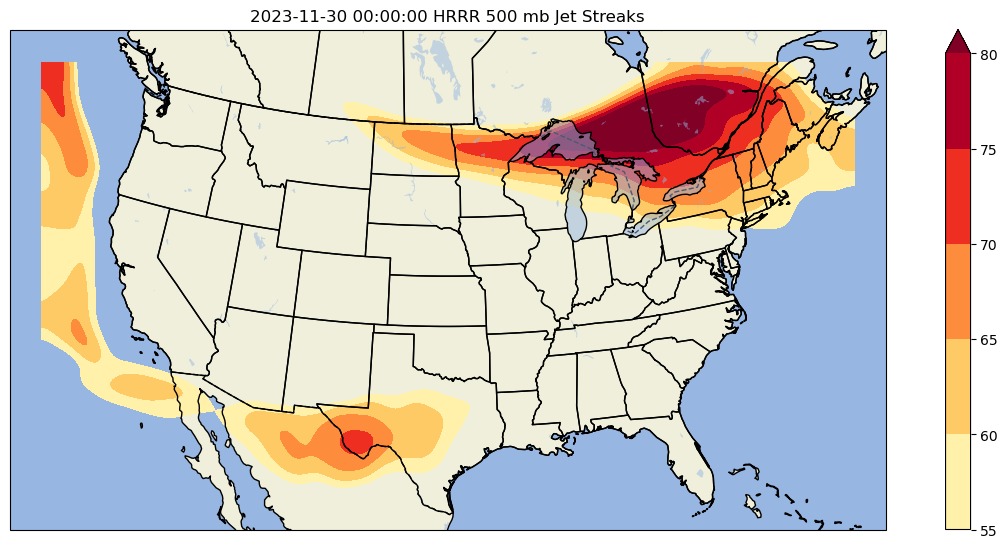

In [32]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([1, 1, 1, 1], projection=lcc)
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.STATES)
ax.set_extent((-125, -70, 22, 52))
cont = ax.contourf(u_500_zarr.x, u_500_zarr.y, gaussian_filter(wspd_500[6] * 1.94, 20), [55, 60, 65, 70, 75, 80], cmap="YlOrRd", extend='max')
plt.colorbar(cont, ax=ax)
plt.title(f"{run_date} HRRR 500 mb Jet Streaks")

Text(0.5, 1.0, '2023-11-30 00:00:00 HRRR 500 mb Jet Streaks')

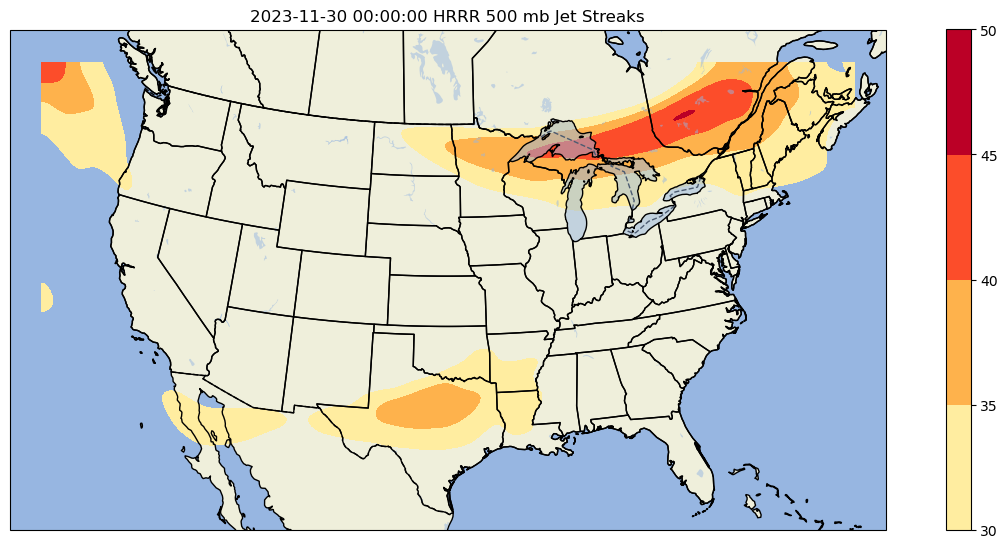

In [25]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_axes([1, 1, 1, 1], projection=lcc)
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.STATES)
ax.set_extent((-125, -70, 22, 52))
cont = ax.contourf(u_500_zarr.x, u_500_zarr.y, gaussian_filter(wspd_500[14], 20), [30, 35, 40, 45, 50], cmap="YlOrRd")
plt.colorbar(cont, ax=ax)
plt.title(f"{run_date} HRRR 500 mb Jet Streaks")

## Jet Tracking
Here is the key part of the notebook for tracking the jets. The tracking process is sensitive to the hyperparameters, so choose ones that
find objects at the scale you are interested in and which will persist objects in time while minimizing drops and unphysical mergers.
1. label_storm_objects: given a time series of 2D scalar fields with blobs in them, identify grid cells that should be grouped together based on similarly high values. Outputs an array with objects indicated by positive integer values. Here we are using the hysteresis method or "hyst" in hagelslag, which performs an initial segmentation to identify areas exceeding a high threshold and then growing them until they reach the low threshold. 
2. extract_storm_objects: Takes the segmented field and creates a list of lists of STObjects for each model time step.
3. track_storms: Takes the STObjects and groups together overlapping ones in time to create tracks. We will derive the translation speeds from the tracked objects.

In [33]:
# I picked min and max thresholds based on hand tuning. Setting too high a max_intensity can cause jets to drop segments.
# Setting too low a min_intensity 
min_intensity = 65 # Any pixel above this value adjacent is added to the initial set of objects based on proximity.
max_intensity = 70 # Objects must contain at least 1 pixel exceeding this value.
min_area = 30 # objects with fewer this this number of pixels are dropped.
gaussian_sd = 20 # standard deviation of gaussian smoother in number of grid cells. Can smooth out small-scale features, like storms.
max_nonoverlap = 0.99 # Ranges from 0 to 1 and provides tolerance for what proportion of non-overlapping pixels is too many for a match.
jet_outlines = tracker.label_storm_objects(wspd_500 * 1.94, "hyst", min_intensity, max_intensity, min_area=30, gaussian_sd=20)
jet_obj_list = tracker.extract_storm_objects(jet_outlines, wspd_500, u_500_zarr.x, u_500_zarr.y, forecast_hours, dx=u_500_zarr.dx)
tracked_jets = tracker.track_storms(jet_obj_list, forecast_hours, [nonoverlap], np.array([max_nonoverlap]), np.array([1.0]))

Found 03 storm objects.


See how the outlines of the jet objects evolve with time.

Text(0.5, 1.0, '2023-11-30 00:00:00 HRRR Jet Streak Outlines')

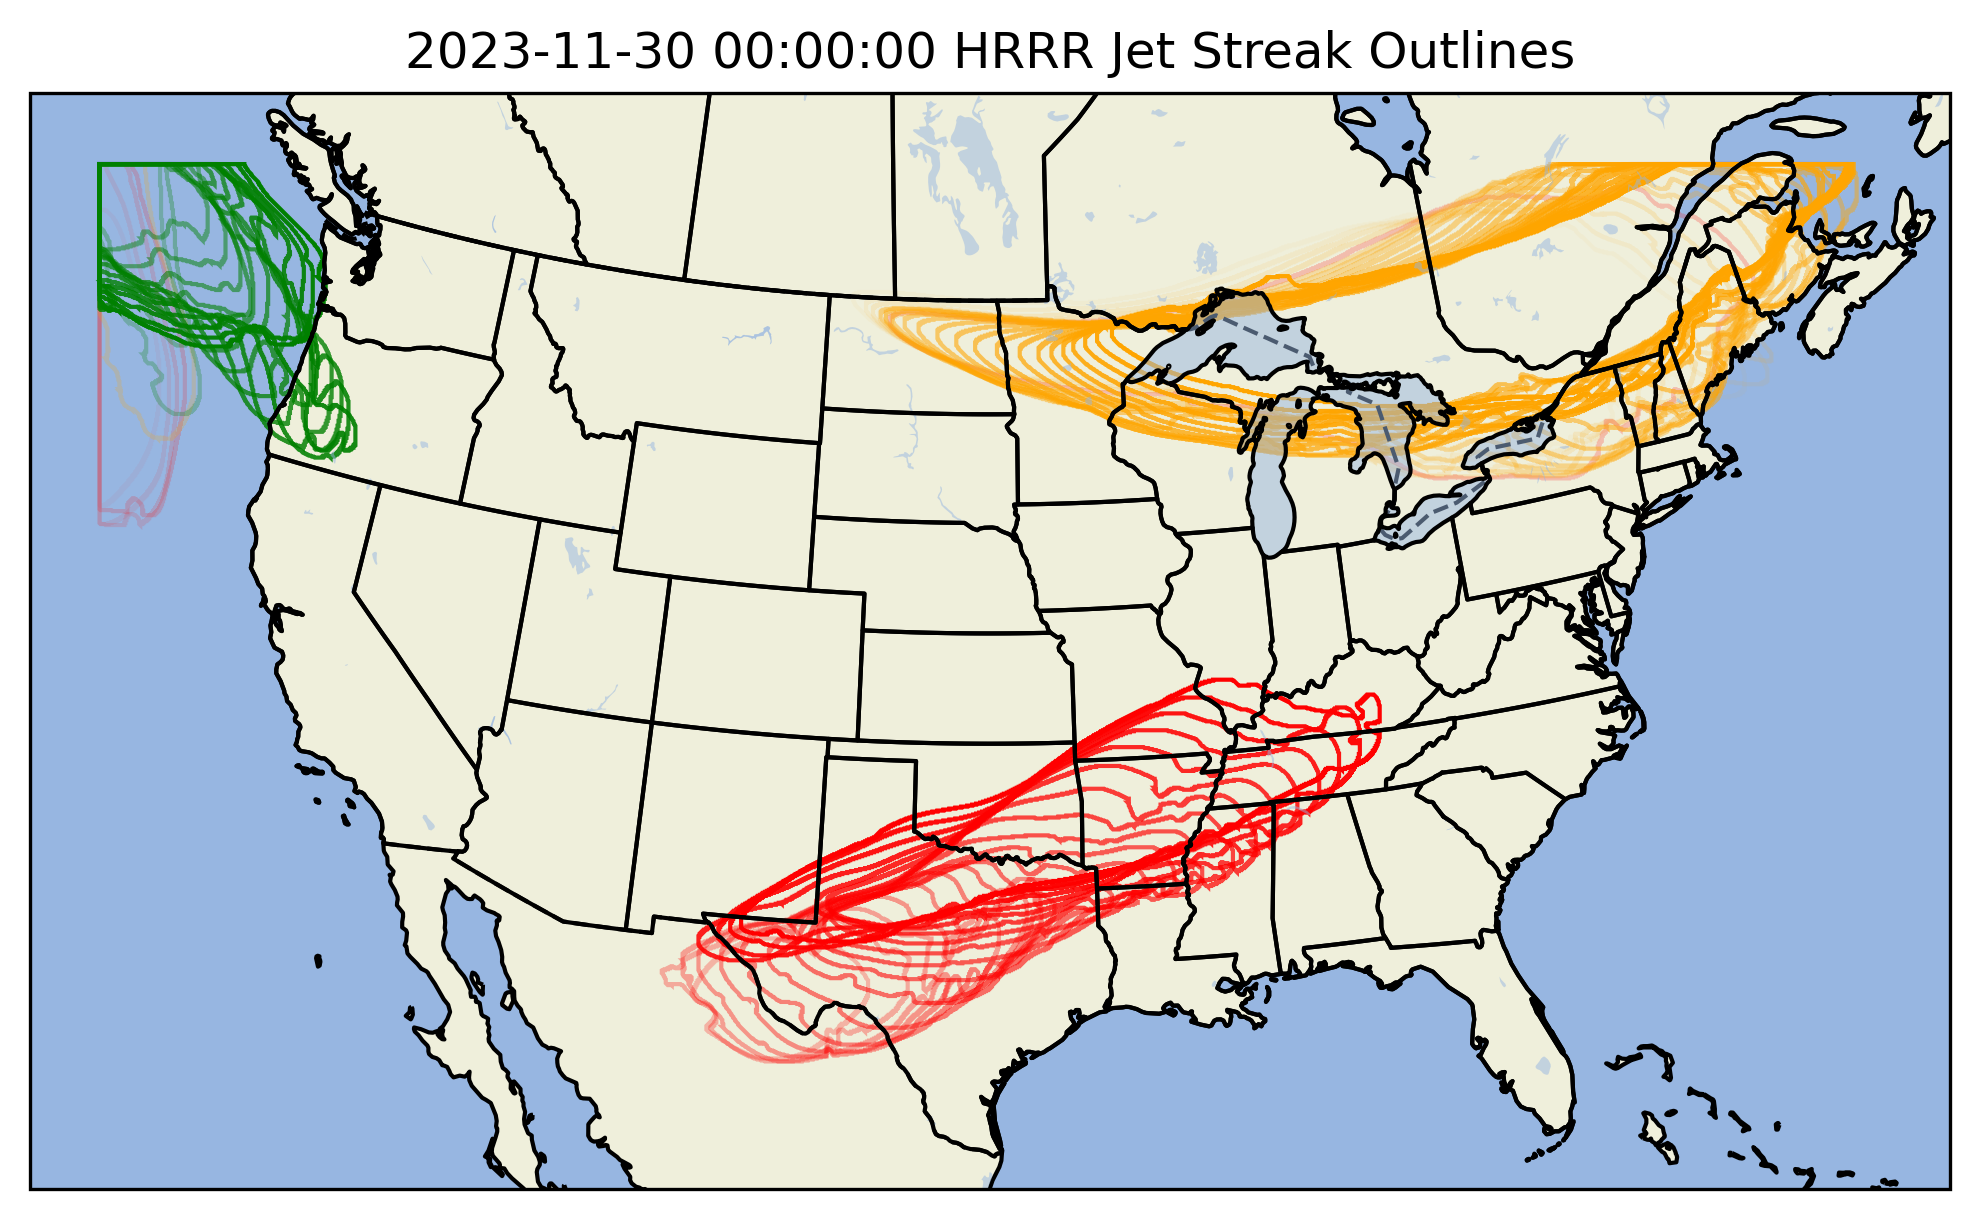

In [34]:
fig = plt.figure(dpi=300)
ax = fig.add_axes([1, 1, 1, 1], projection=lcc)
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.STATES)
ax.set_extent((-125, -70, 22, 52))

colors = ["red", "orange", "green", "blue", "purple"]
for t, jet_objs_t in enumerate(jet_obj_list):
    
    for o, jet_o in enumerate(jet_objs_t):
        p_coords = jet_o.boundary_contour(jet_o.times[0]).T
        ax.fill(p_coords[:, 0], p_coords[:, 1], edgecolor=colors[o], facecolor="none", alpha=t/24)
ax.set_title(f"{run_date} HRRR Jet Streak Outlines")

Here we calculate and visualize the jet translation speed. The colors are random, so re-run the cell again if they don't look good.

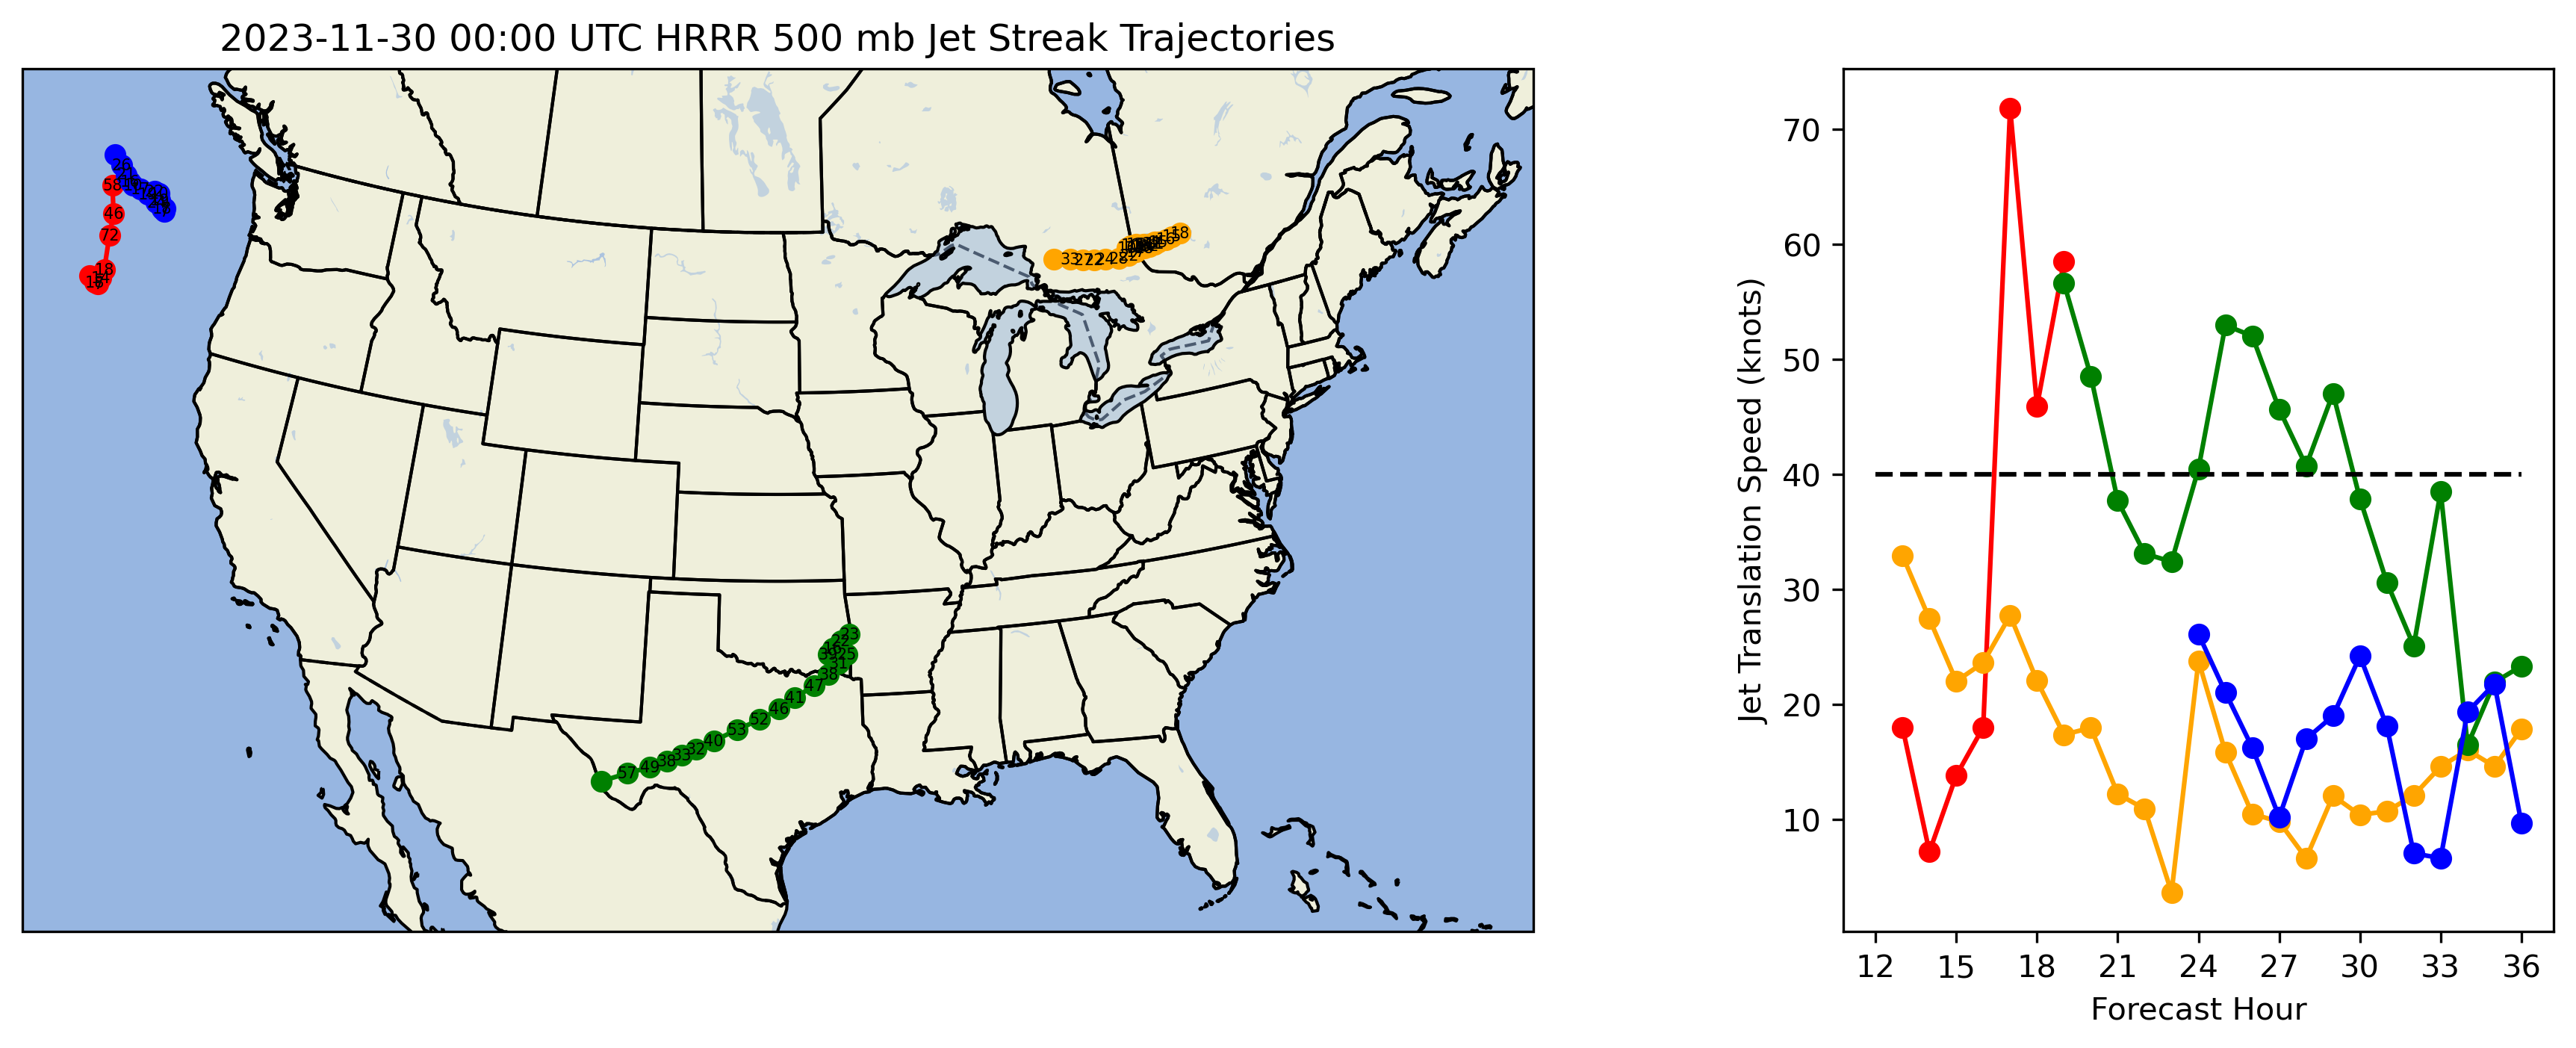

In [40]:
fig = plt.figure(figsize=(15, 5), dpi=300)
gs = gridspec.GridSpec(1, 2, width_ratios=[0.7, 0.3])
ax = fig.add_subplot(gs[0], projection=lcc)
ax.set_facecolor(cfeature.COLORS['water'])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.STATES)
ax.set_extent((-125, -70, 22, 52))
ax2 = fig.add_subplot(gs[1])
track_colors = ListedColormap(["red", "orange", "green", "blue", "purple", "skyblue"])
for j, jet in enumerate(tracked_jets):
    com = np.array([jet.center_of_mass(t) for t in jet.times])
    if com.shape[0] > 1:
        speed = np.sqrt(np.sum((com[1:] - com[:-1]) ** 2, axis=1))/ 3600 * 1.944
        ax2.plot(jet.times[1:], speed, color=track_colors.colors[j], marker='o')
    else:
        speed = [0]
    ax.plot(com[:, 0], com[:, 1], marker='o', color=track_colors.colors[j])
    for c in range(1, com.shape[0]):
        ax.text(com[c, 0], com[c, 1], f"{speed[c-1]:0.0f}", fontsize=5, ha='center', va='center')
ax2.plot(np.arange(12, 37), np.ones(25) * 40, 'k--')
ax2.set_ylabel("Jet Translation Speed (knots)")
ax2.set_xlabel("Forecast Hour")
ax2.set_xticks(forecast_hours[::3])
ax.set_title(run_date.strftime("%Y-%m-%d %H:%M UTC HRRR ") + "500 mb Jet Streak Trajectories")
out_date = run_date.strftime("%Y%m%d_%H%M")
plt.savefig(f"jet_streaks_{out_date}.png", bbox_inches="tight", dpi=300)

Extract relevant data into DataFrames for later analysis. 

In [7]:
jet_frames = []
for j, jet in enumerate(tracked_jets):
    jet_data = {} 
    com = np.array([jet.center_of_mass(t) for t in jet.times])
    jet_data["forecast_hour"] = jet.times
    jet_data["com_x"] = com[:, 0]
    jet_data["com_y"] = com[:, 1]
    if com.shape[0] > 1:
        speed = np.concatenate([[0], np.sqrt(np.sum((com[1:] - com[:-1]) ** 2, axis=1)) / 1000])
    else:
        speed = np.array([0])
    jet_data["translation_speed"] = speed
    jet_data["max_wspd"] = np.array([jet.calc_timestep_statistic("max", t) for t in jet.times])
    jet_frames.append(pd.DataFrame(jet_data))

In [295]:
jet_frames

[    forecast_hour          com_x          com_y  translation_speed   max_wspd
 0               0 -194452.736240 -362285.407517           0.000000  46.085659
 1               1  -95765.534535 -345414.909752         100.118817  45.765888
 2               2  -10383.469921 -322317.211622          88.451120  47.046356
 3               3   60872.714872 -303099.513770          73.802194  47.238270
 4               4  -28519.753949 -366665.275526         109.688739  49.480309
 5               5   32830.676921 -338806.207209          67.379545  49.059277
 6               6  -96974.218474 -374003.170707         134.492145  49.390594
 7               7  -48606.220301 -358315.759035          50.848384  49.615810
 8               8 -131479.638733 -302801.505880          99.748864  50.939381
 9               9  -50640.892960 -270601.906604          87.015614  51.741554
 10             10   36261.409332 -221183.743810          99.970821  51.295712
 11             11  115189.546100 -166252.450463    